# Reading ns-ALEX data from Photon-HDF5

*In this notebook we show how to read a ns-ALEX  smFRET measurement stored in *
*[Photon-HDF5 format](http://photon-hdf5.readthedocs.org/)*
*using python and a few common scientific libraries (numpy, pytables, matplotlib).*
*Specifically, we show how to load timestamps, detectors and nanotimes arrays*
*and how to plot a TCSPC histogram.* 

*For a µs-ALEX example see [Reading µs-ALEX data from Photon-HDF5](Reading µs-ALEX data from Photon-HDF5.ipynb).*

In [1]:
from __future__ import division, print_function  # only needed on py2
%matplotlib inline
import numpy as np
import tables
import matplotlib.pyplot as plt

# 1. Utility functions

Here we define an utility function to print HDF5 file contents:

In [2]:
def print_children(group):
    """Print all the sub-groups in `group` and leaf-nodes children of `group`.

    Parameters:
        group (pytables group): the group to be printed.
    """
    for name, value in group._v_children.items():
        if isinstance(value, tables.Group):
            content = '(Group)'
        else:
            content = value.read()
        print(name)
        print('    Content:     %s' % content)
        print('    Description: %s\n' % value._v_title.decode())

# 2. Open the data file

Let assume we have a Photon-HDF5 file at the following location:

In [3]:
filename = '../data/Pre.hdf5'

We can open the file, as a normal HDF5 file

In [4]:
h5file = tables.open_file(filename)

The object `h5file` is a pytables file reference. The root group is accessed with `h5file.root`.

# 3. Print the content

Let's start by taking a look at the file content:

In [5]:
print_children(h5file.root)

provenance
    Content:     (Group)
    Description: Information about the original data file.

identity
    Content:     (Group)
    Description: Information about the Photon-HDF5 data file.

sample
    Content:     (Group)
    Description: Information about the measured sample.

setup
    Content:     (Group)
    Description: Information about the experimental setup.

photon_data
    Content:     (Group)
    Description: Group containing arrays of photon-data.

acquisition_duration
    Content:     900.0
    Description: Measurement duration in seconds.

user
    Content:     (Group)
    Description: A custom group.

description
    Content:     b'A demonstrative smFRET-nsALEX measurement.'
    Description: A user-defined comment describing the data file.



We see the typical Photon-HDF5 structure. In particular the field `description` provides a short description of the measurement and `acquisition_duration` tells that the acquisition lasted 900 seconds.

As an example, let's take a look at the content of the `sample` group:

In [6]:
print_children(h5file.root.sample)

num_dyes
    Content:     2
    Description: Number of different dyes present in the samples.

buffer_name
    Content:     b'Tris20 mM Ph 7.8'
    Description: A descriptive name for the buffer.

dye_names
    Content:     b'ATTO488, ATTO647N'
    Description: String containing a comma-separated list of dye or fluorophore names.

sample_name
    Content:     b'Doubly-labeled ssDNA partially hybridized to a complementary strand.'
    Description: A descriptive name for the sample.



Let's define a shortcut to the photon_data group to save some typing later:

In [7]:
photon_data = h5file.root.photon_data

# 4. Reading the data

First, we make sure the file contains the right type of measurement:

In [8]:
photon_data.measurement_specs.measurement_type.read().decode()

'smFRET-nsALEX'

Ok, tha's what we espect. 

Now we can load all the `photon_data` arrays an their specs:

In [9]:
timestamps = photon_data.timestamps.read()
timestamps_unit = photon_data.timestamps_specs.timestamps_unit.read()
detectors = photon_data.detectors.read()
nanotimes = photon_data.nanotimes.read()
tcspc_num_bins = photon_data.nanotimes_specs.tcspc_num_bins.read()
tcspc_unit = photon_data.nanotimes_specs.tcspc_unit.read()

In [10]:
print('Number of photons: %d' % timestamps.size)
print('Timestamps unit:   %.2e seconds' % timestamps_unit)
print('TCSPC unit:        %.2e seconds' % tcspc_unit)
print('TCSPC number of bins:    %d' % tcspc_num_bins)
print('Detectors:         %s' % np.unique(detectors))

Number of photons: 20120771
Timestamps unit:   5.00e-08 seconds
TCSPC unit:        1.60e-11 seconds
TCSPC number of bins:    4096
Detectors:         [  0   1 127]


We may want to check the excitation wavelengths used in the measurement. This information is found in the setup group:

In [11]:
h5file.root.setup.excitation_wavelengths.read()

[4.7e-07, 6.35e-07]

Now, let's load the definitions of donor/acceptor channel and excitation periods:

In [12]:
donor_ch = photon_data.measurement_specs.detectors_specs.spectral_ch1.read()
acceptor_ch = photon_data.measurement_specs.detectors_specs.spectral_ch2.read()
print('Donor CH: %d     Acceptor CH: %d' % (donor_ch, acceptor_ch))

Donor CH: 1     Acceptor CH: 0


In [13]:
laser_rep_rate = photon_data.measurement_specs.laser_repetition_rate.read()
donor_period = photon_data.measurement_specs.alex_excitation_period1.read()
acceptor_period = photon_data.measurement_specs.alex_excitation_period2.read()
print('Laser repetion rate: %5.1f MHz \nDonor period:    %s      \nAcceptor period: %s' % \
      (laser_rep_rate*1e-6, donor_period, acceptor_period))

Laser repetion rate:  20.0 MHz 
Donor period:    [1540, 3050]      
Acceptor period: [150, 1500]


These numbers define the donor and acceptor excitation periods as shown below:

$$150 < \widetilde{t} < 1500 \qquad \textrm{donor period}$$

$$1540 < \widetilde{t} < 3050 \qquad \textrm{acceptor period}$$

where $\widetilde{t}$ represent the `nanotimes` array. 

For more information
please refer to the [measurements_specs section](http://photon-hdf5.readthedocs.org/en/latest/phdata.html#measurement-specs)
of the *Reference Documentation*.

# 5. Plotting the TCSPC histogram

Let start by separating nanotimes from donor and acceptor channels:

In [14]:
nanotimes_donor = nanotimes[detectors == donor_ch]
nanotimes_acceptor = nanotimes[detectors == acceptor_ch]

Next, we compute the histograms:

In [15]:
bins = np.arange(0, tcspc_num_bins + 1)
hist_d, _ = np.histogram(nanotimes_donor, bins=bins)
hist_a, _ = np.histogram(nanotimes_acceptor, bins=bins)

And finally we plot the TCSPC histogram using *matplotlib*:

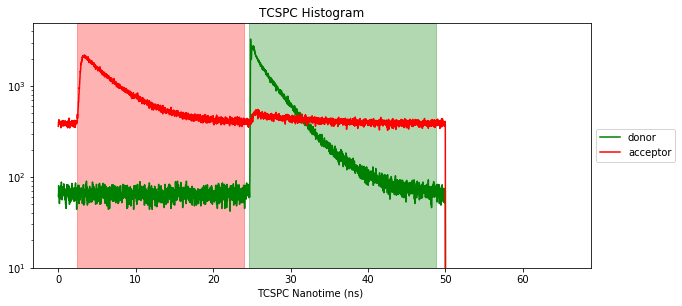

In [16]:
fig, ax = plt.subplots(figsize=(10, 4.5))
scale = tcspc_unit*1e9
ax.plot(bins[:-1]*scale, hist_d, color='green', label='donor')
ax.plot(bins[:-1]*scale, hist_a, color='red', label='acceptor')
ax.axvspan(donor_period[0]*scale, donor_period[1]*scale, alpha=0.3, color='green')
ax.axvspan(acceptor_period[0]*scale, acceptor_period[1]*scale, alpha=0.3, color='red')
ax.set_xlabel('TCSPC Nanotime (ns) ')
ax.set_title('TCSPC Histogram')
ax.set_yscale('log')
ax.set_ylim(10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [17]:
#plt.close('all')